## Vehicle Detection Project

The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier  
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.  
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.  
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.  
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.  
* Estimate a bounding box for vehicles detected.


In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import os
import time
import pickle
import pandas as pd
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from collections import deque

### Feature Extraction

Functions include: transformation of color space, extraction of spatial binned features, color histogram features and HOG features.

In [2]:
def convert_BGR_color(img, color_space):
    # Convert image to new color space (if specified)
    if color_space != 'BGR':
        if color_space == 'HSV':
            new_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            new_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            new_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            new_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            new_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else:
            print("Unsupported color space")
    else: 
        new_image = img
    return new_image

In [3]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features  
def channel_hists(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the channels separately
    hists = [np.histogram(img[:,:,i], bins=nbins, range=bins_range)[0] for i in range(3)]
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate(hists)
    # Return the feature vector
    return hist_features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, trans_sqrt=True, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=trans_sqrt, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=trans_sqrt, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [6]:
# Define a function to extract features from a list of images
def extract_features(img_files, cspaces=['BGR'], types={'spatial_color', 'hist_color', 'hog'}, spatial_size=(32, 32), hist_bins=32, hog_channels={'gray'}, orient=9, pix_per_cell=8, cell_per_block=2, trans_sqrt=True, augment_data=False):
    # Create a list to append feature vectors to
    features = []
    
    if augment_data:
        flipped_list = [False, True]
    else:
        flipped_list = [False]

    # Iterate through the list of images
    for file in img_files:
        # Read in each one by one
        image = cv2.imread(file)
        cimages = {}
        
        for flipped in flipped_list:
            img_features = []
            for cspace in cspaces:
                if cspace not in cimages:
                    cimages[cspace] = convert_BGR_color(image, cspace)
                feature_img = cimages[cspace]
                
                if flipped:
                    feature_img = cv2.flip(feature_img, 1)

                if 'spatial_color' in types:
                    # Apply bin_spatial() to get spatial color features
                    spatial_features = bin_spatial(feature_img, size=spatial_size)
                    img_features.append(spatial_features)
                if 'hist_color' in types:
                    # Apply color_hist() also with a color space option now
                    hist_features = channel_hists(feature_img, nbins=hist_bins)
                    img_features.append(hist_features)
                if 'hog' in types and any(ctype in hog_channels for ctype in ['0', '1', '2', 'ALL']):
                    hog_features = []
                    if 'ALL' in hog_channels:
                        channel_list = range(feature_img.shape[2])
                    else:
                        channel_list = []
                        for ctype in hog_channels:
                            if ctype != 'gray':
                                channel_list.append(int(ctype))
                    for channel in channel_list:
                        hog_features.append(get_hog_features(feature_img[:,:,channel], orient, pix_per_cell, cell_per_block, trans_sqrt))
                    hog_features = np.ravel(hog_features)
                    img_features.append(hog_features)

            if 'hog' in types and 'gray' in hog_channels:
                if not ('ALL' in hog_channels and ('YUV' in cspaces or 'YCrCb' in cspaces)):
                    if 'YUV' in cspaces:
                        gray = cimages['YUV'][:,:,0]
                    elif 'YCrCb' in cspaces:
                        gray = cimages['YCrCb'][:,:,0]
                    else:
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    
                    if flipped:
                        gray = cv2.flip(gray, 1)

                    hog_features = get_hog_features(gray, orient, pix_per_cell, cell_per_block, trans_sqrt)
                    img_features.append(hog_features)

            # Append the new feature vector to the features list
            features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return np.array(features)

### Vehicle Detection Classifier, Linear SVM

Read the data and apply different combinations of color space and features to get a better understanding of what works best.

In [7]:
# Read in our vehicles and non-vehicles
cars_train = []
cars_test = []
notcars_train = []
notcars_test = []

for root, dirs, files in os.walk("data/"):
    for f in files:
        if f.endswith(".png"):
            if "non-vehicles" in root:
                if "train" in root:
                    notcars_train.append(root+"/"+f)
                if "test" in root:
                    notcars_test.append(root+"/"+f)
            elif "vehicles" in root:
                if "train" in root:
                    cars_train.append(root+"/"+f)
                if "test" in root:
                    cars_test.append(root+"/"+f)

In [8]:
# variable parameters
all_cspaces = ['BGR', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb', 'gray']
all_types = {'spatial_color', 'hist_color', 'hog'}
# fixed parameters
spatial = 16
histbin = 32
hog_channels={'ALL'}
orient = 8
pix_per_cell = 8
cell_per_block = 2

exp_id = 0
experiments_dict = {}

for cs in all_cspaces:
    for ty in all_types:
        if cs == "gray":
            if ty == 'hog':
                cspaces=['BGR']
                types={ty}
                hog_channels={'gray'}
            else:
                continue
        else:
            cspaces=[cs]
            types={ty}

        print("Starting experiment: ", cs, ty)

        t=time.time()
        car_train_features = extract_features(cars_train, cspaces=cspaces, types=types, spatial_size=(spatial,spatial),
                                hist_bins=histbin, hog_channels=hog_channels, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, augment_data=False)
        car_test_features = extract_features(cars_test, cspaces=cspaces, types=types, spatial_size=(spatial,spatial),
                                hist_bins=histbin, hog_channels=hog_channels, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, augment_data=False)
        notcar_train_features = extract_features(notcars_train, cspaces=cspaces, types=types, spatial_size=(spatial,spatial),
                                hist_bins=histbin, hog_channels=hog_channels, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, augment_data=False)
        notcar_test_features = extract_features(notcars_test, cspaces=cspaces, types=types, spatial_size=(spatial,spatial),
                                hist_bins=histbin, hog_channels=hog_channels, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, augment_data=False)

        t2 = time.time()
        extraction_time = t2-t
        print(round(extraction_time, 2), 'Seconds to extract features...')

        # Create an array stack of feature vectors
        X_train = np.vstack((car_train_features, notcar_train_features)).astype(np.float64)                        
        X_test = np.vstack((car_test_features, notcar_test_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X_train)
        # Apply the scaler to X
        scaled_X_train = X_scaler.transform(X_train)
        scaled_X_test = X_scaler.transform(X_test)

        # Define the labels vector
        y_train = np.hstack((np.ones(len(car_train_features)), np.zeros(len(notcar_train_features))))
        y_test = np.hstack((np.ones(len(car_test_features)), np.zeros(len(notcar_test_features))))

        data_dict = {}
        data_dict["cspaces"] = cspaces
        data_dict["types"] = types
        data_dict["spatial_size"] = spatial
        data_dict["hist_bins"] = histbin
        data_dict["hog_channels"] = hog_channels
        data_dict["orient"] = orient
        data_dict["pix_per_cell"] = pix_per_cell
        data_dict["cell_per_block"] = cell_per_block

        data_dict["train_size"] = len(scaled_X_train)
        data_dict["test_size"] = len(scaled_X_test)

        data_dict["feature_size"] = len(scaled_X_train[0])
        print('Feature vector length:', data_dict["feature_size"])

        data_dict["extraction_time"] = extraction_time

        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(scaled_X_train, y_train)
        t2 = time.time()
        data_dict["train_time"] = t2-t
        print(round(data_dict["train_time"], 2), 'Seconds to train SVC...')
        # Check the prediction time for a single sample
        t=time.time()
        svc.predict(scaled_X_test)
        t2 = time.time()
        data_dict["predict_time"] = t2-t
        print(round(data_dict["predict_time"], 5), 'Seconds to predict', len(scaled_X_test),'labels with SVC')
        # Check the score of the SVC
        data_dict["test_accuracy"] = svc.score(scaled_X_test, y_test)
        print('Test Accuracy of SVC = ', round(data_dict["test_accuracy"], 4))
        print()

        experiments_dict[exp_id] = data_dict
        exp_id += 1

Starting experiment:  BGR hist_color
37.8 Seconds to extract features...
Feature vector length: 96
5.79 Seconds to train SVC...
0.00069 Seconds to predict 3546 labels with SVC
Test Accuracy of SVC =  0.8675

Starting experiment:  BGR hog
120.03 Seconds to extract features...
Feature vector length: 4704
21.84 Seconds to train SVC...
0.0172 Seconds to predict 3546 labels with SVC
Test Accuracy of SVC =  0.9571

Starting experiment:  BGR spatial_color
17.14 Seconds to extract features...
Feature vector length: 768
16.71 Seconds to train SVC...
0.00303 Seconds to predict 3546 labels with SVC
Test Accuracy of SVC =  0.9069

Starting experiment:  HSV hist_color
24.11 Seconds to extract features...
Feature vector length: 96
4.27 Seconds to train SVC...
0.00089 Seconds to predict 3546 labels with SVC
Test Accuracy of SVC =  0.8644

Starting experiment:  HSV hog
110.64 Seconds to extract features...
Feature vector length: 4704
13.7 Seconds to train SVC...
0.01761 Seconds to predict 3546 labels 

### List of Parameter Results Sorted by Test Set Accuracy

In [9]:
df = pd.DataFrame.from_dict(experiments_dict, orient="index")
df.sort_values("test_accuracy", ascending=0)

,cspaces,types,spatial_size,hist_bins,hog_channels,orient,pix_per_cell,cell_per_block,train_size,test_size,feature_size,extraction_time,train_time,predict_time,test_accuracy
7,[LUV],{hog},16,32,{ALL},8,8,2,14214,3546,4704,109.975837,13.074215,0.017635,0.982234
13,[YUV],{hog},16,32,{ALL},8,8,2,14214,3546,4704,104.910757,11.595480,0.016480,0.981387
16,[YCrCb],{hog},16,32,{ALL},8,8,2,14214,3546,4704,105.441543,11.641084,0.017313,0.977721
4,[HSV],{hog},16,32,{ALL},8,8,2,14214,3546,4704,110.644565,13.700562,0.017611,0.970389
10,[HLS],{hog},16,32,{ALL},8,8,2,14214,3546,4704,97.830759,13.521057,0.034778,0.968979
1,[BGR],{hog},16,32,{ALL},8,8,2,14214,3546,4704,120.032220,21.842935,0.017202,0.957135
18,[BGR],{hog},16,32,{gray},8,8,2,14214,3546,1568,37.009691,8.835516,0.006991,0.943034
2,[BGR],{spatial_color},16,32,{ALL},8,8,2,14214,3546,768,17.137893,16.706610,0.003029,0.906937
14,[YUV],{spatial_color},16,32,{ALL},8,8,2,14214,3546,768,11.090000,15.092055,0.002984,0.906373
17,[YCrCb],{spatial_color},16,32,{ALL},8,8,2,14214,3546,768,17.558256,14.610039,0.004126,0.899323


### Training SVM Classifer with Final Parameters on All Data

In [10]:
cspaces = ['LUV']
types = {'spatial_color', 'hist_color', 'hog'}
spatial = 16
histbin = 32
hog_channels={'0'}
orient = 8
pix_per_cell = 8
cell_per_block = 2

car_train_features = extract_features(cars_train, cspaces=cspaces, types=types, spatial_size=(spatial,spatial),
                        hist_bins=histbin, hog_channels=hog_channels, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, augment_data=True)
car_test_features = extract_features(cars_test, cspaces=cspaces, types=types, spatial_size=(spatial,spatial),
                        hist_bins=histbin, hog_channels=hog_channels, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, augment_data=True)
notcar_train_features = extract_features(notcars_train, cspaces=cspaces, types=types, spatial_size=(spatial,spatial),
                        hist_bins=histbin, hog_channels=hog_channels, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, augment_data=True)
notcar_test_features = extract_features(notcars_test, cspaces=cspaces, types=types, spatial_size=(spatial,spatial),
                        hist_bins=histbin, hog_channels=hog_channels, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, augment_data=True)

# Create an array stack of feature vectors
X_train = np.vstack((car_train_features, car_test_features, notcar_train_features, notcar_test_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)

# Define the labels vector
y_train = np.hstack((np.ones(len(car_train_features)), np.ones(len(car_test_features)), np.zeros(len(notcar_train_features)), np.zeros(len(notcar_test_features))))

# Train linear SVM
svc = LinearSVC(C=0.0001)
svc.fit(scaled_X_train, y_train)
train_accuracy = svc.score(scaled_X_train, y_train)
print('Train Accuracy of SVC = ', round(train_accuracy, 4))
print()

Train Accuracy of SVC =  0.9914



### Visualization of Features on a Car and Non-Car Image

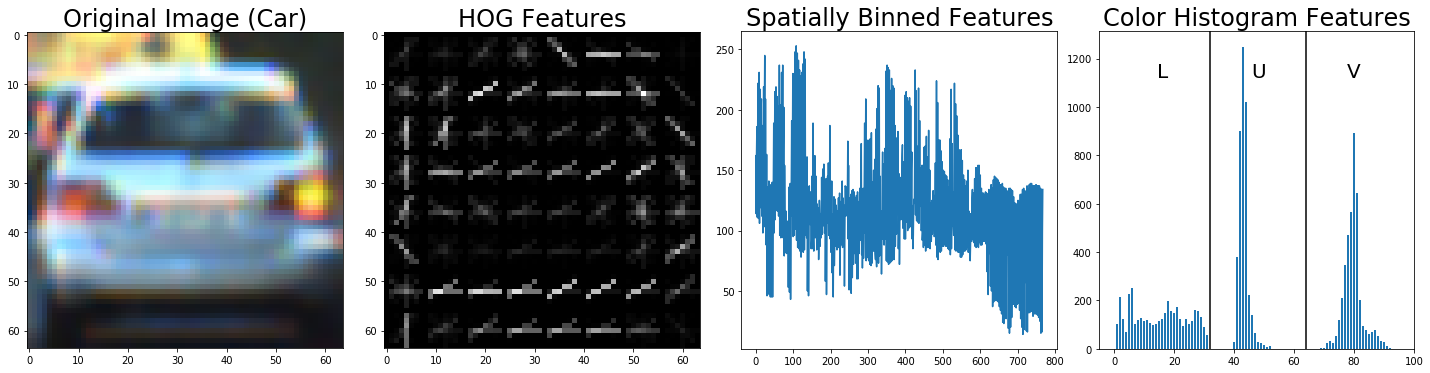

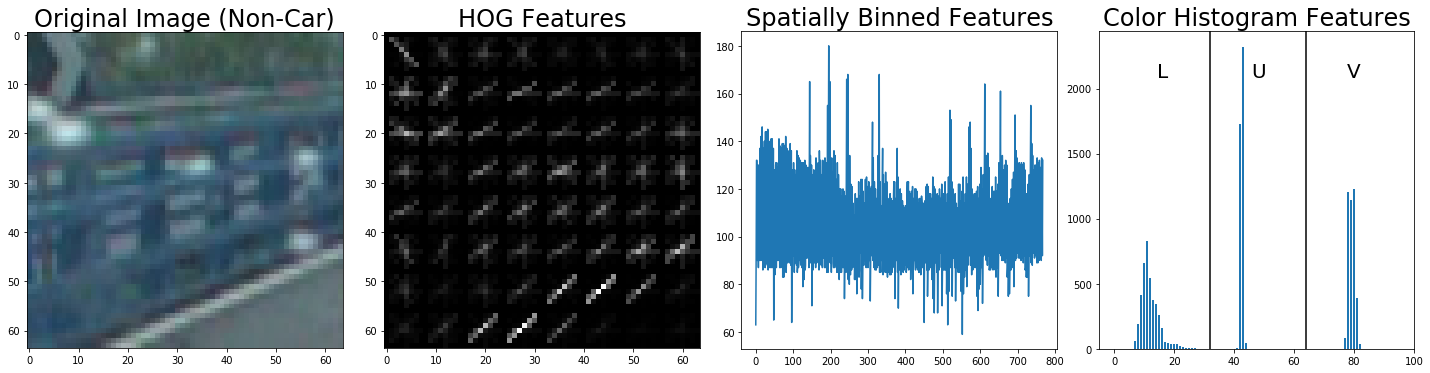

In [11]:
idx = 6993

# Read images
car_img = cv2.imread(cars_train[idx])
notcar_img = cv2.imread(notcars_train[idx])

# Convert color space
car_LUV = convert_BGR_color(car_img, "LUV")
notcar_LUV = convert_BGR_color(notcar_img, "LUV")

# HOG features
_, car_hog_img = get_hog_features(car_LUV[:,:,0], 8, 8, 2, True, vis=True)
_, notcar_hog_img = get_hog_features(notcar_LUV[:,:,0], 8, 8, 2, True, vis=True)

# Spatial color features
car_spatial_features = bin_spatial(car_LUV, size=(16,16))
notcar_spatial_features = bin_spatial(notcar_LUV, size=(16,16))

# Histogram of colors
car_hist_features = channel_hists(car_LUV, nbins=32)
notcar_hist_features = channel_hists(notcar_LUV, nbins=32)



# Plot car image and features
font_size = 24
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
f.tight_layout()

ax1.imshow(car_img[:,:,::-1])
ax1.set_title('Original Image (Car)', fontsize=font_size)

ax2.imshow(car_hog_img, cmap="gray")
ax2.set_title('HOG Features', fontsize=font_size)

ax3.plot(car_spatial_features)
ax3.set_title('Spatially Binned Features', fontsize=font_size)

ax4.bar(np.arange(96), car_hist_features)
ax4.axvline(x=32, c='black')
ax4.axvline(x=64, c='black')
top = 0.9 * max(car_hist_features)
ax4.text(16, top ,"L", fontsize=20, ha="center")
ax4.text(48, top ,"U", fontsize=20, ha="center")
ax4.text(80, top ,"V", fontsize=20, ha="center")
ax4.set_title('Color Histogram Features', fontsize=font_size)

plt.show()


# Plot non-car image and features
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
f.tight_layout()

ax1.imshow(notcar_img[:,:,::-1])
ax1.set_title('Original Image (Non-Car)', fontsize=font_size)

ax2.imshow(notcar_hog_img, cmap="gray")
ax2.set_title('HOG Features', fontsize=font_size)

ax3.plot(notcar_spatial_features)
ax3.set_title('Spatially Binned Features', fontsize=font_size)

ax4.bar(np.arange(96), notcar_hist_features)
ax4.axvline(x=32, c='black')
ax4.axvline(x=64, c='black')
top = 0.9 * max(notcar_hist_features)
ax4.text(16, top ,"L", fontsize=20, ha="center")
ax4.text(48, top ,"U", fontsize=20, ha="center")
ax4.text(80, top ,"V", fontsize=20, ha="center")
ax4.set_title('Color Histogram Features', fontsize=font_size)

plt.show()

### Optimized Code for Feature Extraction using Window Search

Includes helper functions for building a heatmap, applying a threshold on array data and drawing bounding boxes.

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
        
    img_tosearch = img[ystart:ystop,:,::-1]
    ctrans_tosearch = convert_BGR_color(img_tosearch, 'LUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = channel_hists(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return bboxes, img
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, subset=None):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        if subset is None or car_number in subset:
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            bbox_list.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bbox_list 

### Visualization of Pipeline for Single Image Detections

Iterates over several scales of the same image, finds positive detections of vehicles using a window search and maps the detections to a heatmap. The final car detections are done by calculating a bounding box on the heatmap data.

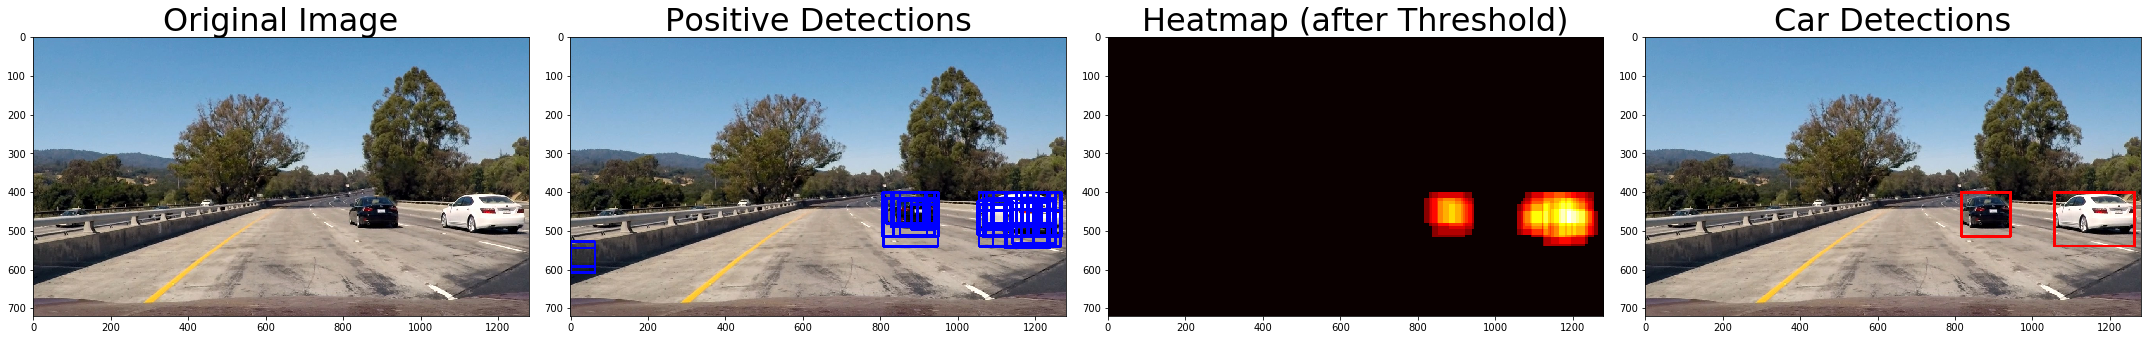

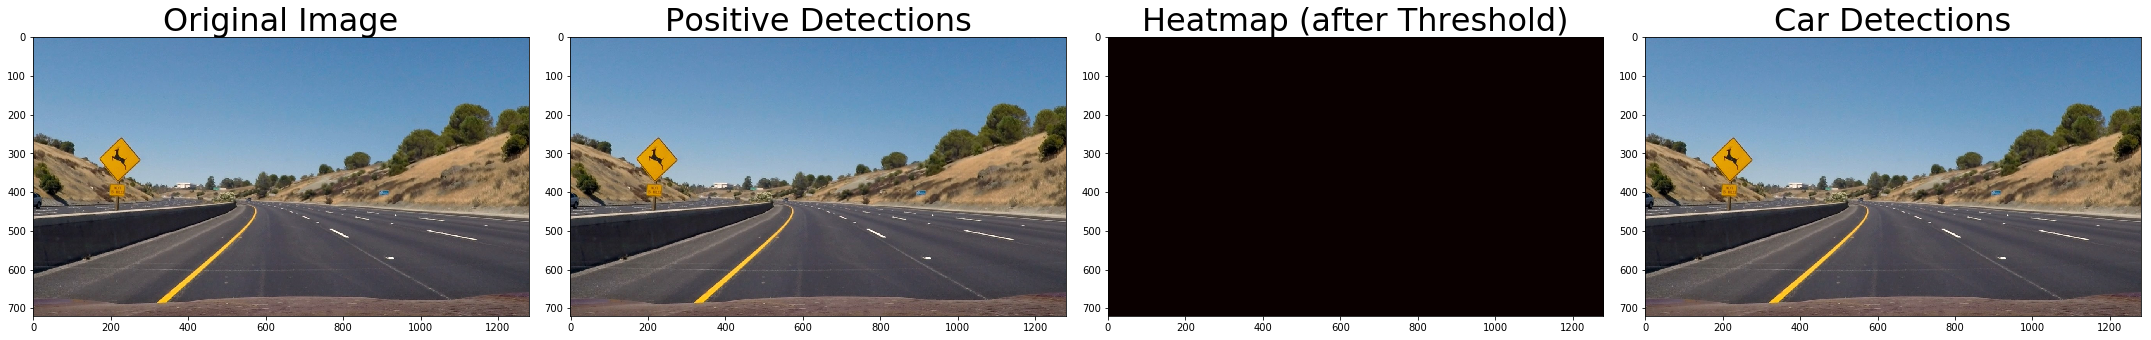

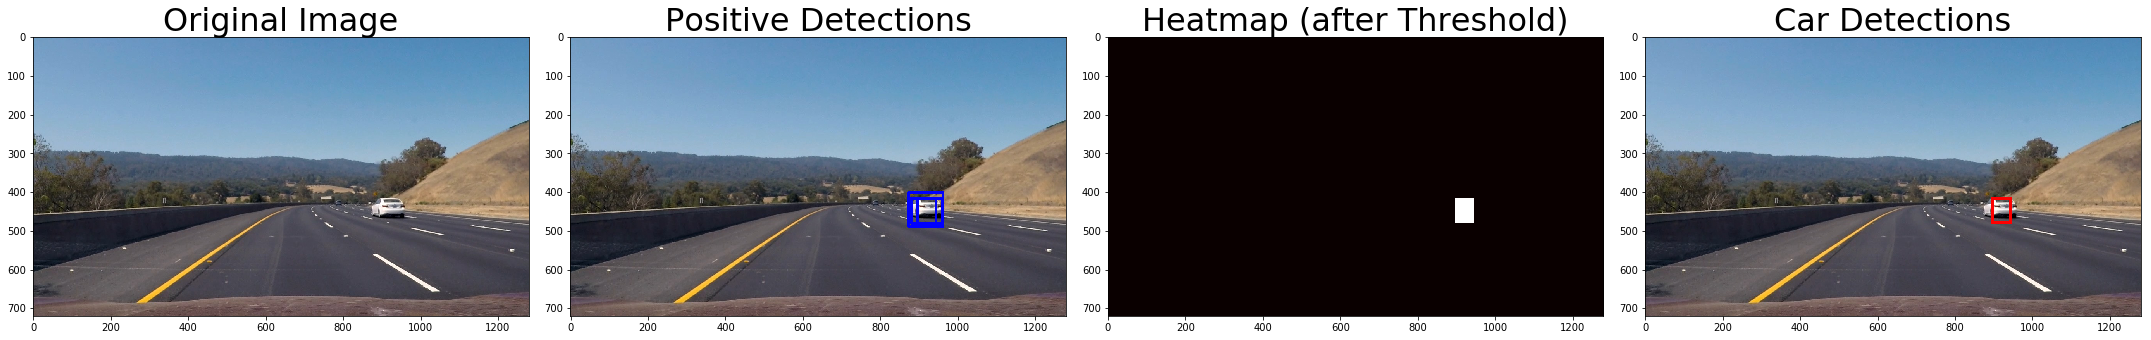

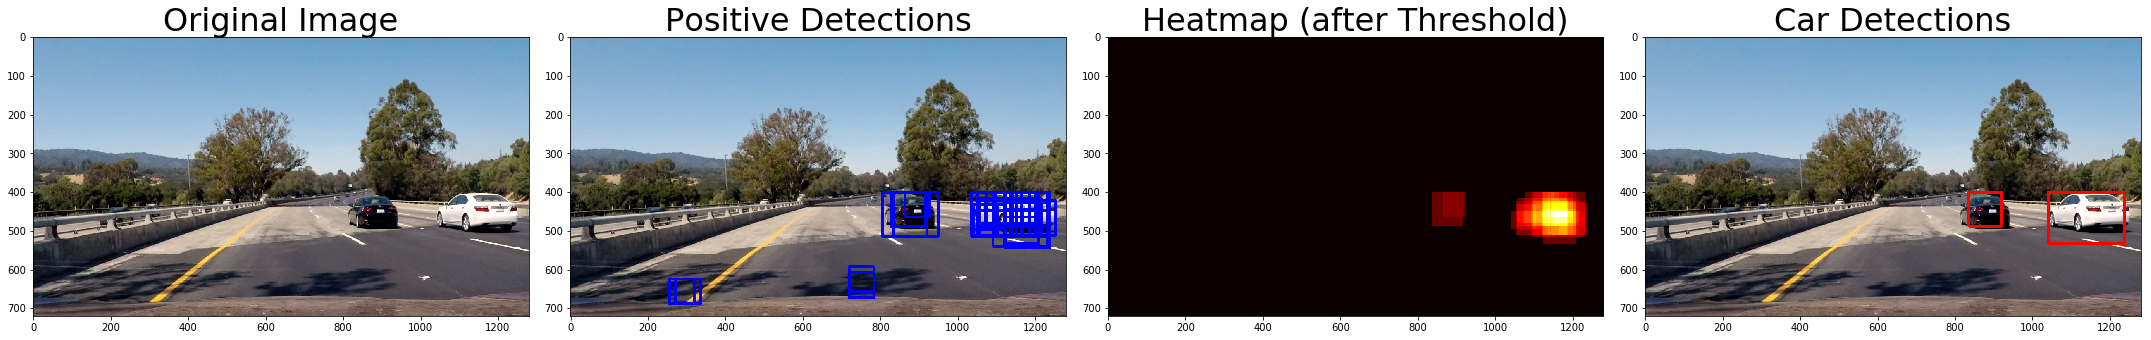

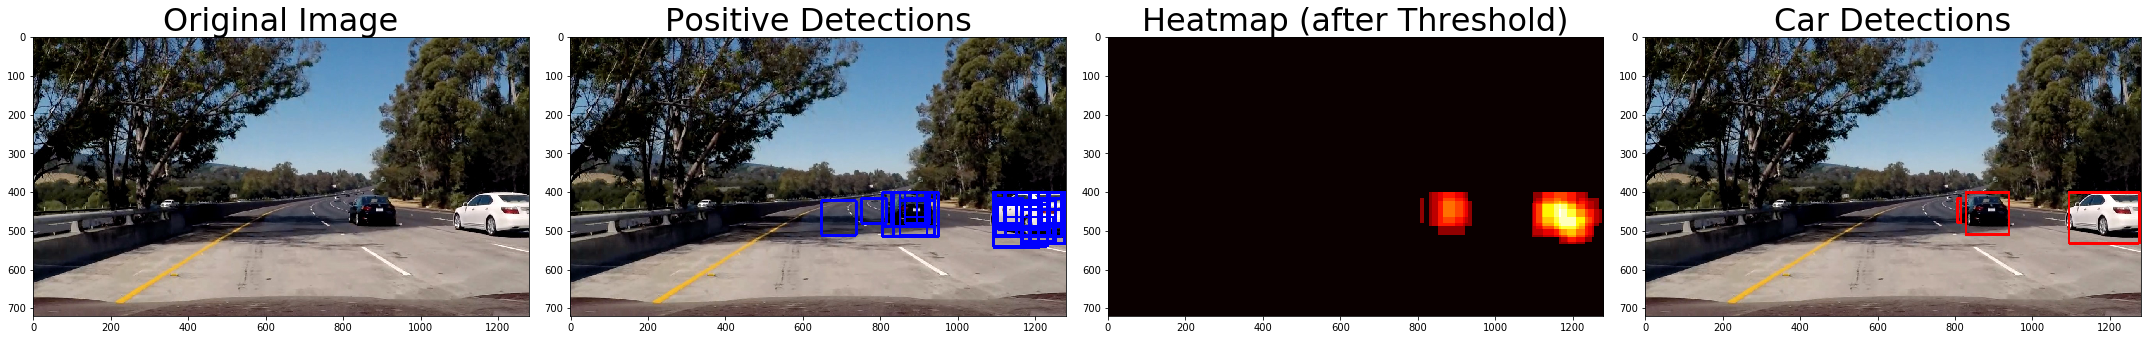

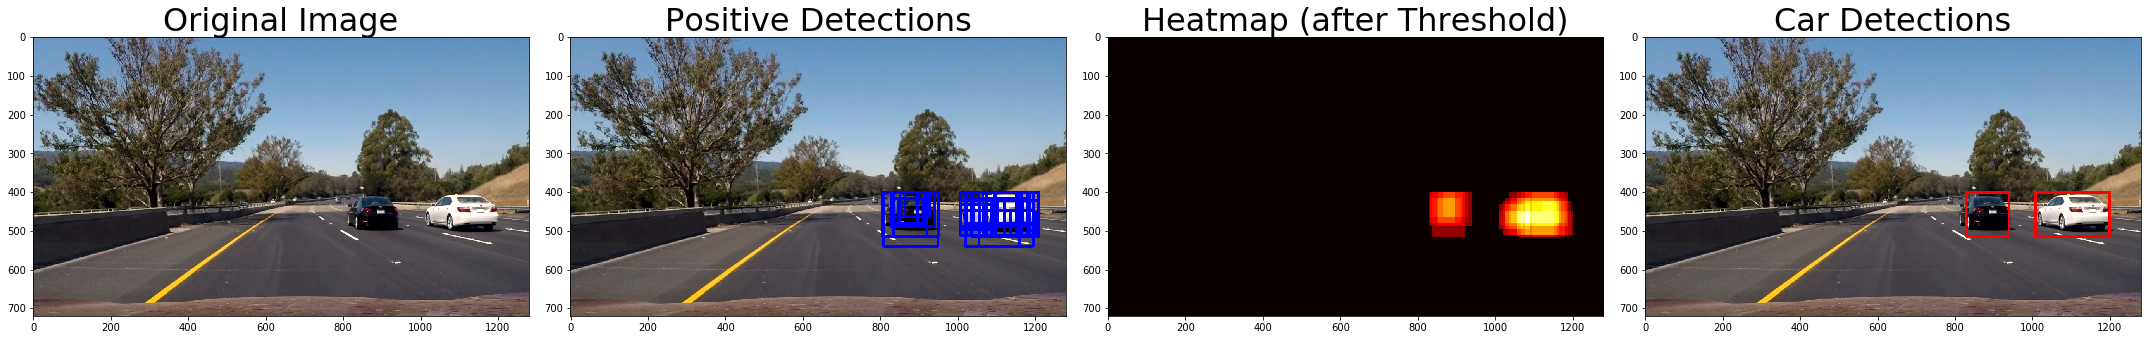

In [13]:
# Evaluation on test images
ystart = 400
ystop = 700

for i in range(6):
    img = cv2.imread('test_images/test'+str(i+1)+'.jpg')
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    out_img = np.copy(img)
    for scale in np.arange(1, 3.1, 0.4):
        bboxes, _ = find_cars(img[:,:,::-1], ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (16,16), 32)

        for bbox in bboxes:
            cv2.rectangle(out_img, bbox[0], bbox[1], (255,0,0), 6)

        # Add heat to each box in box list
        heat = add_heat(heat, bboxes)
        

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, bbox_list = draw_labeled_bboxes(np.copy(img), labels)
    
    # Plot
    font_size = 32
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))
    f.tight_layout()

    ax1.imshow(img[:,:,::-1])
    ax1.set_title('Original Image', fontsize=font_size)

    ax2.imshow(out_img[:,:,::-1])
    ax2.set_title('Positive Detections', fontsize=font_size)

    ax3.imshow(heatmap, cmap='hot')
    ax3.set_title('Heatmap (after Threshold)', fontsize=font_size)

    ax4.imshow(draw_img[:,:,::-1])
    ax4.set_title('Car Detections', fontsize=font_size)
    plt.show()

### Full Image Processor Pipeline for Video Streams

Analyzes a sequence of images by detecting cars where the classifier returns a positive results several frames in a row or where previously vehicles were detected. Additionally, the bounding boxes are smoothes over several frames to get a fluid tracking output.

In [14]:
# Pipeline that processes a sequence of image data
class ImageProcessorPipeline:
    def __init__(self, img_size=(720,1280), eval_every=2, car_detect_frames=8, inc_car_bounds=0.25, gamma=0.8, ybounds=(400, 700), classifier=svc, feature_scaler=X_scaler, orient=8, pix_per_cell=8, cell_per_block=2, spatial_size=(16,16), hist_bins=32, debug_output=False):
        # evaluate only every 'eval_every' frames
        self.eval_every = eval_every
        self.frame_offset = -1
        # how many subsequent frames have to be detected at the same position to make it a car
        self.car_detect_frames = car_detect_frames
        # search 'inc_car_bounds' percent around previously known car position for new detections
        self.inc_car_bounds = inc_car_bounds
        # smoothing factor for heatmaps: gamma * previous heatmap + (1 - gamma) * new heatmap
        self.gamma = gamma
        # bounds of the image that is search for cars (in y direction)
        self.ystart = ybounds[0]
        self.ystop = ybounds[1]
        # classifier to be used, e.g. SVM
        self.classifier = classifier
        # feature scaler to be used
        self.feature_scaler = X_scaler
        # HOG parameters
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        # color feature parameters
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        # determine if debug output should be returned as side-image
        self.debug_output = debug_output
        # initialization of algorithm variables
        self.label_hist = deque()
        self.last_heat = None
        self.bbox_list = None
        self.labels = None
        self.last_debug = None

    def __call__(self, img):     
        # evaluate only every 'self.eval_every' frames
        self.frame_offset += 1
        if self.frame_offset % self.eval_every != 0:
            # this frame is not processed
            if self.labels is not None:
                # the previous bounding boxes are applied to the current frame
                draw_img, _ = draw_labeled_bboxes(np.copy(img), self.labels)  
            else:
                # no bounding boxes yet -> simply return input image
                draw_img = img
        else:
            # this frame is processed
            self.frame_offset = 0
            
            # find cars for all scales and store the positive detection boxes in box_list
            box_list = []
            for scale in np.arange(1, 3.1, 0.4):
                bboxes, out_img = find_cars(img, self.ystart, self.ystop, scale, self.classifier, self.feature_scaler, self.orient, self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins)
                box_list.extend(bboxes)

            # initialize heatmap
            heat = np.zeros_like(img[:,:,0]).astype(np.float)

            # add heat to each box in box list
            heat = add_heat(heat, box_list)

            # apply threshold to help remove false positives
            heatmap = apply_threshold(heat, 1)
            
            # find boxes from heatmap using label function
            labels = label(heatmap)
            # store labels of the last processed frames
            self.label_hist.append(labels)
            
            # always keep the last 'self.car_detect_frames' frame labels in the data structure (self.label_hist)
            if len(self.label_hist) == self.car_detect_frames+1:
                # remove the oldest labels
                self.label_hist.popleft()
            if len(self.label_hist) == self.car_detect_frames:
                # extract labels that occur in all of the previous 'self.car_detect_frames' frames
                car_labels = np.unique(labels[0][np.all(np.dstack([self.label_hist[i][0] for i in range(self.car_detect_frames)]), axis=2)])
                scar_labels = set(car_labels)
                new_car_heatmap = np.copy(heatmap)
                # set the heatmap values to 0 if it was not detected as car (occuring in all of the last frames)
                for l_num in range(1,labels[1]+1):
                    if l_num not in scar_labels:
                        new_car_heatmap[labels[0] == l_num] = 0

                # create a mask that is one for the area of previously detected vehicles 
                # (with increased bounds of 'self.inc_car_bounds' percent) and zero otherwise
                noncar_area = np.ones_like(heatmap, dtype=bool)
                if self.bbox_list is not None:
                    for bbox in self.bbox_list:
                        x_min, y_min, x_max, y_max = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
                        xdist, ydist = x_max-x_min, y_max-y_min
                        x_min = int(np.maximum(0, x_min - self.inc_car_bounds * xdist))
                        y_min = int(np.maximum(0, y_min - self.inc_car_bounds * ydist))
                        x_max = int(np.minimum(img.shape[1], x_max + self.inc_car_bounds * xdist))
                        y_max = int(np.minimum(img.shape[0], y_max + self.inc_car_bounds * ydist))
                        noncar_area[y_min:y_max, x_min:x_max] = False
                prev_cars_heatmap = np.copy(heatmap)
                # apply the mask to the current heatmap
                prev_cars_heatmap[noncar_area] = 0

                # heatmap of the current frame is the combination of new car detections and detections around previous vehicles
                final_heatmap = np.maximum(new_car_heatmap, prev_cars_heatmap)

                # apply exponential smoothing using the previous heatmap and updating it with the new one from this frame
                if self.last_heat is None:
                    self.last_heat = final_heatmap
                else:
                    self.last_heat = self.last_heat * self.gamma + final_heatmap * (1-self.gamma)

                # apply a gaussian blue to the heatmap to further smooth out the area and get rid of the window search grid
                self.last_heat = cv2.GaussianBlur(self.last_heat, (15, 15), 0)

                # apply a final threshold because the label functions detect everything that is greater as 0 as a detection
                self.last_heat = apply_threshold(self.last_heat, 1)

                # extract labels to be final classification of cars
                labels = label(self.last_heat)
                self.labels = labels
                # draw labels on image
                draw_img, self.bbox_list = draw_labeled_bboxes(np.copy(img), labels)
                
                # add debug output image if requested
                if self.debug_output:
                    # debug image contains information about: 
                    # the raw detected heatmap (red color channel)
                    # the new car detected heatmaps (green color channel) -> occur as yellow or white
                    # the previous vehicle surrounding area (blue color channel) -> occur as purple or white
                    # if the image is white it means that all channels trigger, i.e., it is a recurring and previous detection
                    debug_img = np.dstack((heatmap, new_car_heatmap, prev_cars_heatmap))
                    debug_img = (debug_img / np.max(debug_img)*255).astype(np.uint8)
                    self.last_debug = debug_img

            else:
                draw_img = img
        
        # return detection image
        if self.debug_output:
            if self.last_debug == None:
                self.last_debug = np.zeros_like(draw_img)
            result = np.concatenate((draw_img, self.last_debug), axis=1)
        else:
            result = draw_img
        return result

### Evaluate on Videos

In [15]:
video_output = "videos/test_video_detection.mp4"
clip = VideoFileClip("videos/test_video.mp4")
video_clip = clip.fl_image(ImageProcessorPipeline())
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video videos/test_video_detection.mp4
[MoviePy] Writing video videos/test_video_detection.mp4


 97%|█████████▋| 38/39 [00:43<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/test_video_detection.mp4 

CPU times: user 45.9 s, sys: 1.18 s, total: 47.1 s
Wall time: 45.1 s


In [16]:
video_output = "videos/project_video_detection.mp4"
clip = VideoFileClip("videos/project_video.mp4")
video_clip = clip.fl_image(ImageProcessorPipeline())
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video videos/project_video_detection.mp4
[MoviePy] Writing video videos/project_video_detection.mp4


100%|█████████▉| 1260/1261 [25:00<00:01,  1.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_detection.mp4 

CPU times: user 26min 6s, sys: 49 s, total: 26min 55s
Wall time: 25min 2s
